In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from modem import qpsk, chirp, wav, estimate
from modem.constants import FS, DATA_BLOCK_LENGTH, BYTES_BLOCK_LENGTH

hello from qpsk.py


In [2]:
rng = np.random.default_rng(seed=42)
data_bytes = [bytes(rng.integers(256, size=BYTES_BLOCK_LENGTH, dtype=np.uint8)) for i in range(10)]
qpsk_symbols = [qpsk.qpsk_encode(data) for data in data_bytes]
ofdm_symbols = [qpsk.encode_ofdm_symbol(qpsk_syms)[0] for qpsk_syms in qpsk_symbols]
signal = np.concatenate((chirp.START_CHIRP, *ofdm_symbols, chirp.END_CHIRP))

In [3]:
wav.generate_wav("chirp_ofdm_symbols.wav", signal)

Saved to C:\Users\jonti\SynologyDrive\Documents\Uni\IIA\Project-GF3\audio_modem_2025\src\modem\..\..\files\chirp_ofdm_symbols.wav


In [4]:
recv_signal = wav.read_wav("2025-05-28_LT5.wav")

start_lag = np.int64(102832), end_lag = np.int64(253234), difference = np.int64(150402), expected_difference = 150400


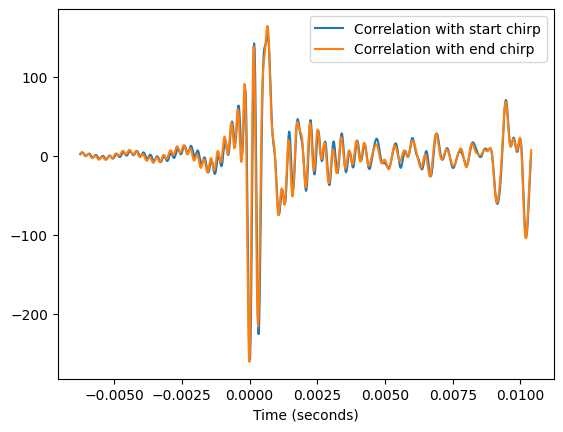

In [5]:
aligned_recv_signal = chirp.synchronise(recv_signal, sum(map(len, ofdm_symbols)), plot_correlations=True)
recv_ofdm_symbols = np.split(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size], len(ofdm_symbols))

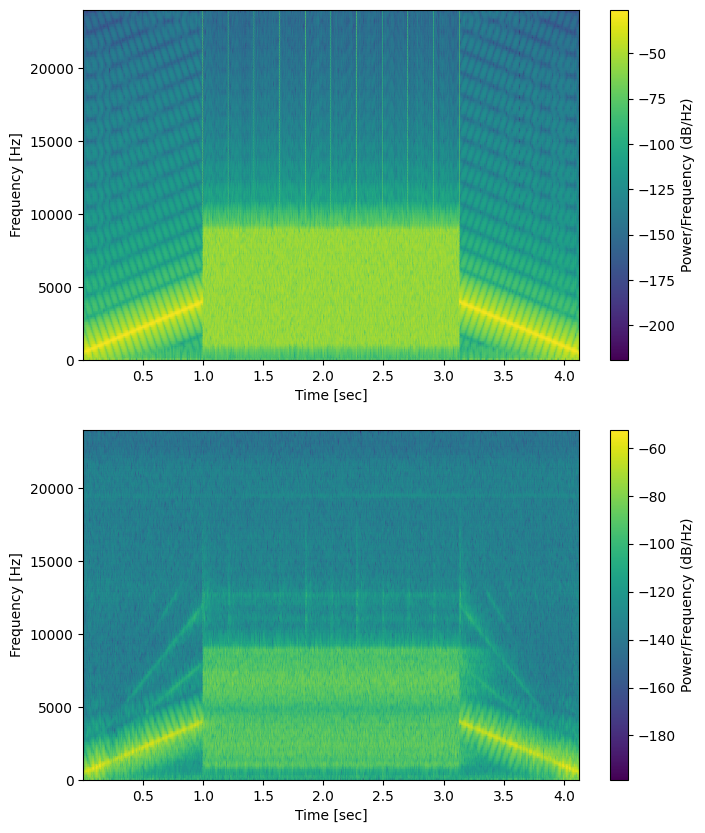

In [6]:
fig, axs = plt.subplots(2, figsize=(8, 10))
axs: tuple[plt.Axes]

for sig, ax in zip((signal, aligned_recv_signal), axs):
    f, t_spec, Sxx = scipy.signal.spectrogram(sig, FS)

    pcm = ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    cbar = fig.colorbar(pcm, ax=ax, label='Power/Frequency (dB/Hz)')

In [7]:
# Use all white noise blocks as pilot symbols and average all gains together
# TODO: in future, should allocate some to be data blocks and find error rate
frequency_gains = np.array([qpsk.decode_ofdm_symbol(recv_sym[np.newaxis, :], np.ones((1, DATA_BLOCK_LENGTH)))[0] / qpsk_syms
                   for recv_sym, qpsk_syms in zip(recv_ofdm_symbols, qpsk_symbols, strict=True)])
avg_gain = np.mean(frequency_gains, axis=0)

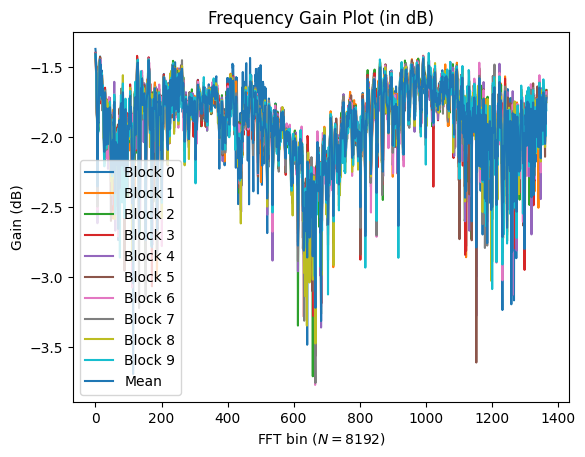

In [8]:
fig, ax = plt.subplots()
for i, block_gain in enumerate(frequency_gains):
    ax.plot(np.log10(np.abs(block_gain)), label=f"Block {i}")
ax.plot(np.log10(np.abs(avg_gain)), label="Mean")
ax.set_title('Frequency Gain Plot (in dB)')
ax.set_xlabel('FFT bin ($N = 8192$)')
ax.set_ylabel('Gain (dB)')
ax.legend()

In [9]:
recv_qpsk_symbols = [qpsk.decode_ofdm_symbol(recv_sym[np.newaxis, :], avg_gain[np.newaxis, :])[0] for recv_sym in recv_ofdm_symbols]

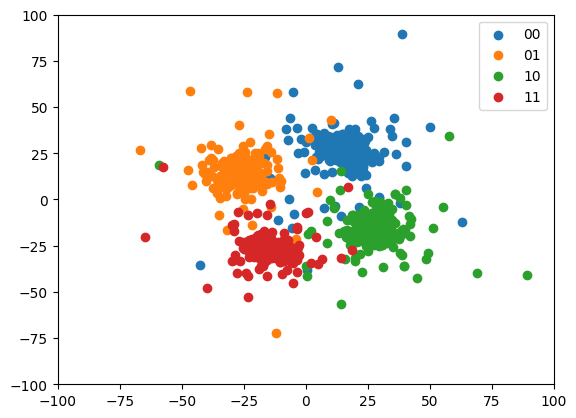

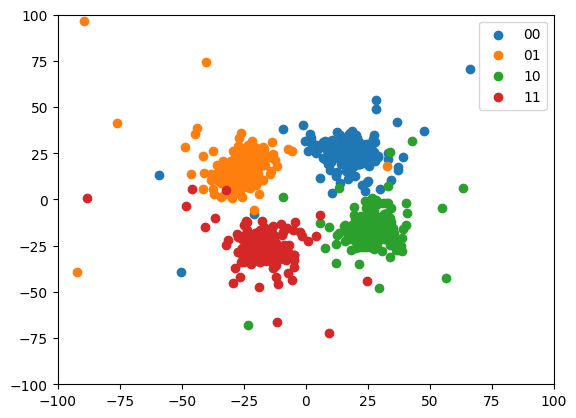

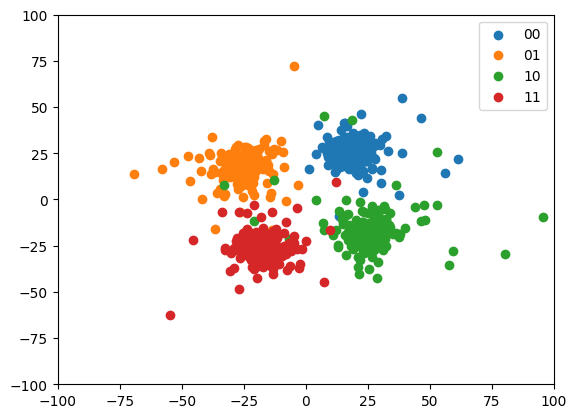

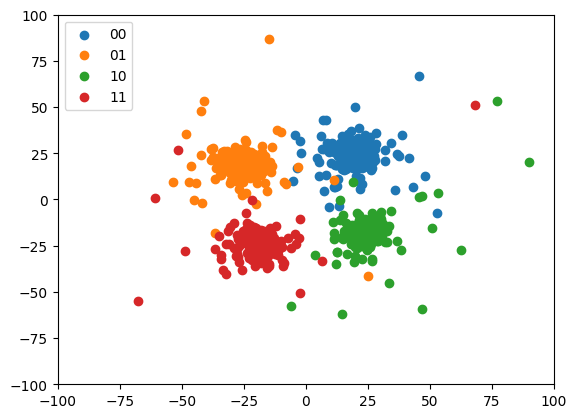

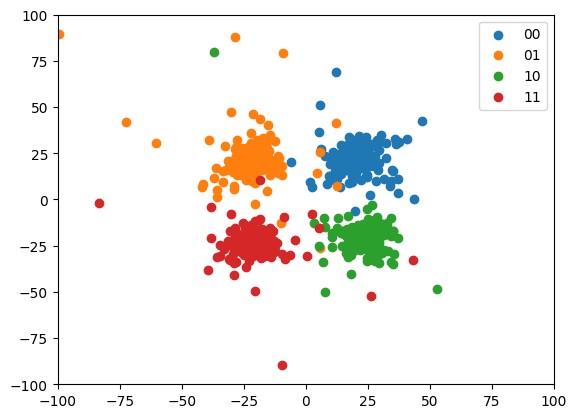

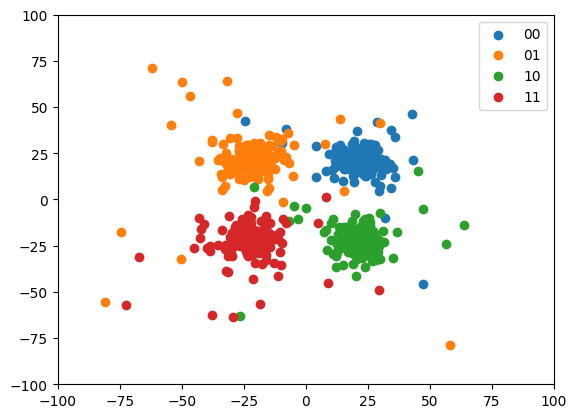

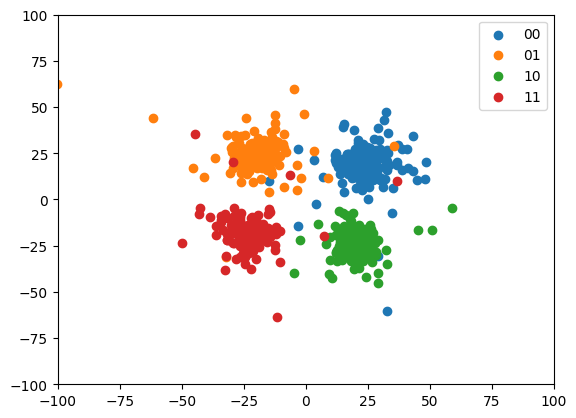

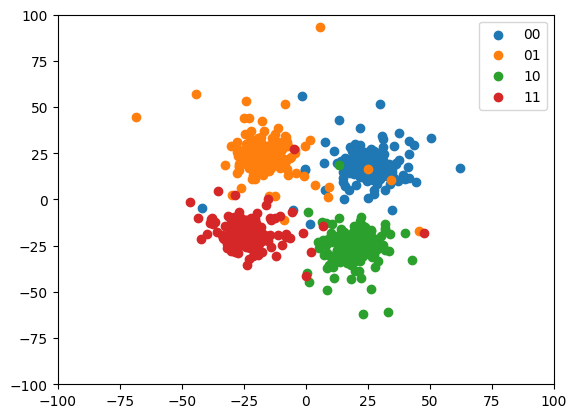

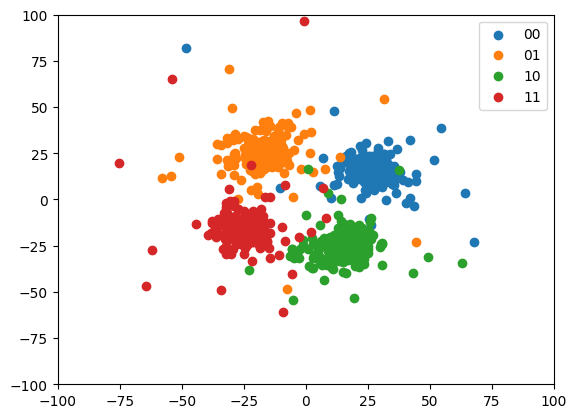

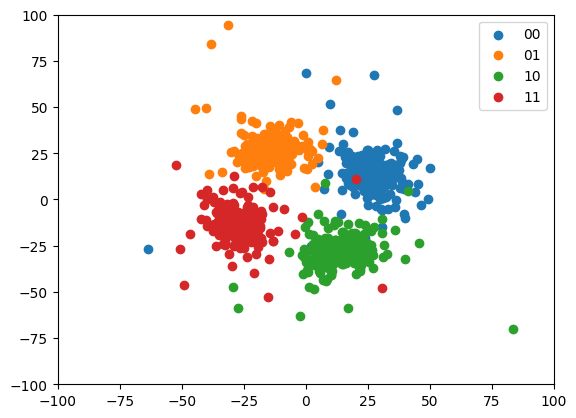

In [10]:
for i in range(10):
    # Create boolean masks to color received symbols based on what the transmitted symbol was
    high_freq_mask = np.zeros_like(qpsk_symbols[i], dtype=np.bool)
    high_freq_mask[100:1000] = True
    positive_real_mask = np.real(qpsk_symbols[i]) > 0
    positive_imag_mask = np.imag(qpsk_symbols[i]) > 0
    mask_00 = positive_real_mask & positive_imag_mask # & high_freq_mask
    mask_01 = (~positive_real_mask) & positive_imag_mask # & high_freq_mask
    mask_11 = (~positive_real_mask) & (~positive_imag_mask) # & high_freq_mask
    mask_10 = positive_real_mask & (~positive_imag_mask) # & high_freq_mask

    # snr = estimate.estimate_snr(qpsk_symbols[i][high_freq_mask], recv_qpsk_symbols[i][high_freq_mask])
    # phase_shift = estimate.avg_phase_shift(qpsk_symbols[i][high_freq_mask], recv_qpsk_symbols[i][high_freq_mask])
    # print(f"For block {i}, SNR is {snr} dB, phase shift is {phase_shift} rad")

    # Plot received symbols
    fig, ax = plt.subplots()
    for mask, bits in ((mask_00, "00"), (mask_01, "01"), (mask_10, "10"), (mask_11, "11")):
        ax.scatter(np.real(recv_qpsk_symbols[i][mask]), np.imag(recv_qpsk_symbols[i][mask]), label=bits)

    ax_limit = 100
    ax.set_xlim(-ax_limit, ax_limit)
    ax.set_ylim(-ax_limit, ax_limit)
    ax.legend()